#### Predicting Temperature over next 10,000 years
This project will explore various time-series machine learning models to predict ice-core temperatures in 10,000-year increments, ultimately with the goal of predicting the temperature over the next 10,000 years. First we'll import some stuff. Time_Series_Pytorch is a library consisting of custom classes that variously use Ridge regression, Pytorch RNN Encoder-Decoder networks, and Pytorch LSTM Encoder-Decoder networks to train, predict, cross-validate, and plot predictions/targets. 

In [45]:
import sys, importlib, Time_Series_PyTorch
import torch, random, numpy, scipy, pandas, matplotlib, statsmodels
importlib.reload(Time_Series_PyTorch)
from Time_Series_PyTorch import *
from statsmodels.graphics.tsaplots   import plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss
torch.manual_seed(1)
random.seed(1)
numpy.random.seed(1)

#### Importing the temperature data set and examining the sampling frequency. 
Going to import temperature data from the EPICA-C core in Antarctica. You can find this data set here: https://www.ncei.noaa.gov/access/paleo-search/study/6080. It covers a span of roughly 800,000 years ago up till now. The temperature data taken from ice cores is not sampled at regular time intervals, as we can see from the Time Step Interval plot. The intervals range from close to 0 years all the way up to 1400 years. We can see from the Temperature plot that the temperature data has way more oscillations as the sampling frequency increases. 

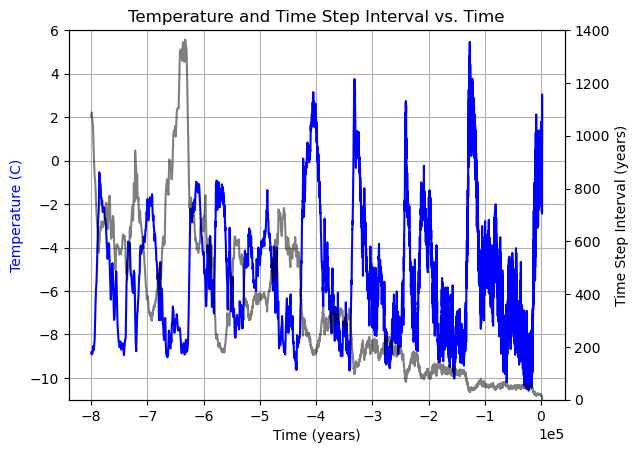

In [65]:
df_Temp = pandas.read_excel("EPICA_C_Temp.xlsx")
df_Temp = df_Temp[["age_calBP", "Temperature"]]
df_Temp.columns = ["Time", "Temp"]
df_Temp.dropna(inplace=True)
df_Temp["Time"] = df_Temp["Time"].apply(lambda x: -x + 1950)     # changing temporal variable from 'low long before 1950' to time since 0 BC
df_Temp.sort_values(by = "Time", ascending = True, inplace = True)   # putting everything in chronological order
df_Temp.reset_index(inplace = True)
Time = df_Temp["Time"].values
Time_Step = [Time[j+1] - Time[j] for j in range(len(Time)-1)] + [0]
Temp = df_Temp["Temp"].values
pyplot.figure()
ax = pyplot.axes()
ax.plot(Time, Temp, color = "blue")
ax.set_ylabel("Temperature (C)", color = "blue")
ax.set_xlabel("Time (years)")
ax.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
ax.set_ylim(-11,6)
ax_2 = ax.twinx()
ax_2.plot(Time, Time_Step, color = "black", alpha = 0.5)
ax_2.set_ylabel("Time Step Interval (years)", color = "black")
ax_2.set_ylim(0,1400)
ax.set_title("Temperature and Time Step Interval vs. Time")
ax.grid()

To construct a series suitable for Time Series analysis, I need to fix a constant sampling period. I'll choose 500 years, somewhat arbitrarily, as a compromise value between the extremes. So I'll interpolate the data (linearly for simplicity) and resample it with a time step of 500 years. I'll plot the original and resampled data for comparison.

Text(0.5, 1.0, 'Temperature vs. Time')

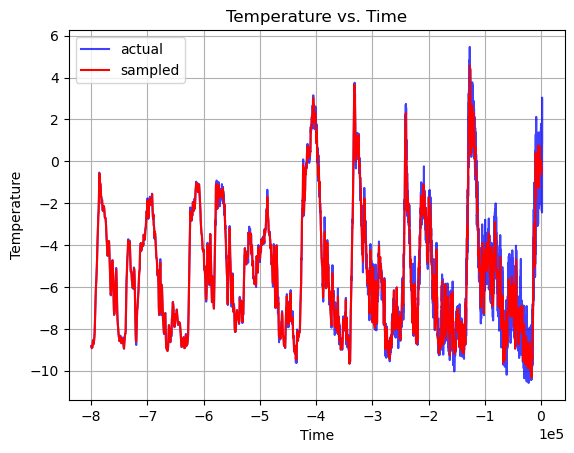

In [47]:
Temp_INTERP = scipy.interpolate.interp1d(df_Temp["Time"], df_Temp["Temp"], kind="linear")
D1 = df_Temp["Time"]
R1 = df_Temp["Temp"]
D2 = numpy.array(range(-799500,1500,500)) 
R2 = Temp_INTERP(D2)
pyplot.plot(D1, R1, color="blue", label="actual", alpha = 0.75)
pyplot.plot(D2, R2, color="red", label="sampled")
pyplot.legend()
pyplot.grid()
pyplot.xlabel("Time")
pyplot.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
pyplot.ylabel("Temperature")
pyplot.title("Temperature vs. Time")

#### Applying Time Series Models
I'd like to take the T_seq data above and predict the temperature 10,000 years (20 time steps) in advance. I'll use an expanding window approach to compare different models. I'll train on T_seq[0:1300] and predict T_seq[1300:1320], train on T_seq[0:1320], and predict T_seq[1320:1340], ..., train on T_seq[0:1580], and predict T_seq[1580:1600]. Then I'll calculate the mean square error for each time step across all training/predicting runs. The model with the lowest mse wins. I'll use this model to predict the next the temperature over the next 10,000 years, i.e., T_seq[1600:1620]. Note that time-step 1600 corresponds to the year 0 CE. 

First, noticing an oscillatory pattern, we might try a **sinusoidal fit** to the data. We can use a rolling average to try to separate fluctuations from the underlying trend/seasonality. I'll average over a 100 time-step window centered on the given time. We can see the roughly 100,000-year (200 time-step) Milankovich cycle.

C:\Users\atdou\Climate-Change\Time_Series_PyTorch.py:398: RuntimeWarning: Mean of empty slice.
  return numpy.array(self.seq[x-half_T:x+half_T]).mean()
C:\Users\atdou\anaconda3\envs\ev1b\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


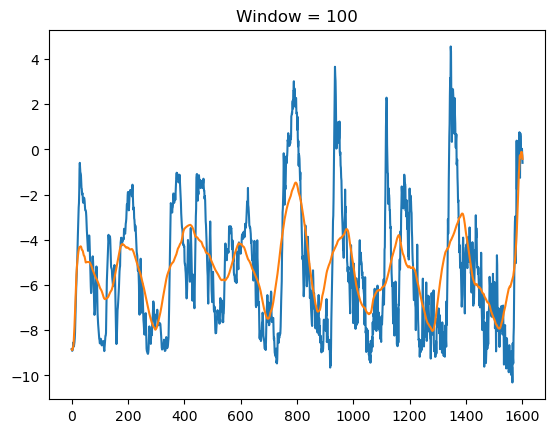

In [48]:
Y = pandas.Series(numpy.array(range(-799500,1500,500)))
T_seq = pandas.Series(Temp_INTERP(Y))
roll_ave = rolling_average(T_seq, 100)
roll_ave.plot(Domain = None)

So this looks somewhat sinusoidal, with an offset. So let's try a simple sinusoidal forecaster. This will fit a sinusoid on T_seq[0:1300] and use it to predict T_seq[1300:1320], etc., until the end. We don't get great results.

<Figure size 640x480 with 0 Axes>

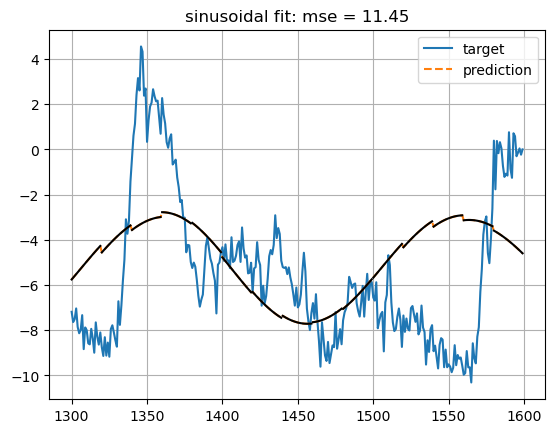

In [49]:
from lmfit import Parameters, Minimizer, report_fit 
params = Parameters()
params.add("A", value = 5)
params.add("T", value = 200)
params.add("phi", value = 0) 
params.add("C", value = -4) 
def model(params, x):
    A = params["A"]
    T = params["T"]
    phi = params["phi"]
    C = params["C"]
    return A*numpy.cos(2*3.14*x/T + phi) + C
def residual(params, x, y):
    A = params["A"]
    T = params["T"]
    phi = params["phi"]
    C = params["C"]
    residual = A*numpy.cos(2*3.14*x/T + phi) + C  - y
    return residual

X_seq = pandas.Series(list(range(1600)))
tsf_lmfit = lmfit_Forecaster(params, model, residual, Minimizer)
tsf_lmfit.cross_val_exp(X = X_seq, y = T_seq, X_seq_start = 0, y_seq_length = 20, test_indices = list(range(1300,1600,20)))
mse_lmfit = tsf_lmfit.cv_results["mse_fold"].mean()
tsf_lmfit.plot_targets_predictions(kind = "expanding", title = "sinusoidal fit: mse = {:.2f}".format(mse_lmfit,2))

Another good baseline model to try is a **random walk model**. This just takes the present value as the prediction for the next 20 time-steps. This is quite a bit better, with an mse = 4.45, which means that it's off by roughly sqrt(4.45) = 2.1 degrees for each of the predicted 20 data points. But of course we'd like to do better than a model that predicts no change.

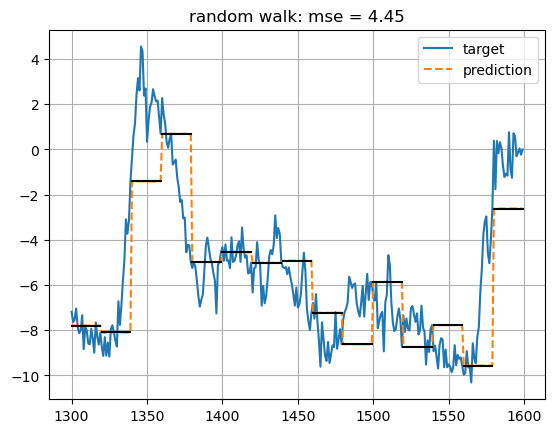

In [50]:
df = create_dataframe(X_seq_length = 1, y_seq_length = 1)      # creates a dataframe 
df.fit(T_seq.values)
df.insert_constant(1)
X, y = df.X, df.y
tsf_des = DES_Forecaster(X_seq_length = 1, y_seq_length = 20, coefs = [1,0])
tsf_des.cross_val(X, y, test_indices = list(range(1300,1600,20)))
mse_des = tsf_des.cv_results["mse_fold"].mean()
tsf_des.plot_targets_predictions(title = "random walk: mse = {:.2f}".format(mse_des))

Let's try a more sophisticated model. We'll try **ARIMA**. First, though our series isn't really stationary, we'll just apply the AD-Fuller and KPSS tests as a check. They say it's stationary - enough. 

In [51]:
ad = adfuller(T_seq)
kp = kpss(T_seq)
print("AD-Fuller = " + str(ad))
print("KPSS = " + str(kp))

AD-Fuller = (-5.875107098939816, 3.173014181316402e-07, 24, 1577, {'1%': -3.4345034408379527, '5%': -2.863374496477375, '10%': -2.567746652650719}, 2820.1008083090155)
KPSS = (0.06869623154004774, 0.1, 25, {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})


C:\Users\atdou\AppData\Local\Temp\ipykernel_2964\2336689960.py:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kp = kpss(T_seq)


We'll also plot the partial autocorrelation function. It shows that the first lag term has the highest correlation. Beyond that, there is a smaller but perhaps non-trivial correlation. 

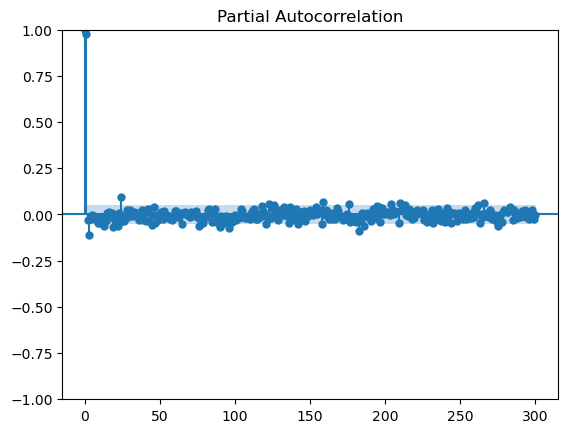

In [52]:
plot_pacf(T_seq, lags = 300)
pyplot.show()

I'll just try a generic ARIMA. A model with d = 1, p = 0, q = 0 corresponds to the random walk model we tried above. Let's do d = 1, p = 5, q = 1. That doesn't improve things much. Neither does, say, d = 0, p = 5, q = 1. Best fit so far has a mse of 3.9. Trying more advanced ARIMA models is very time-consuming.

<Figure size 640x480 with 0 Axes>

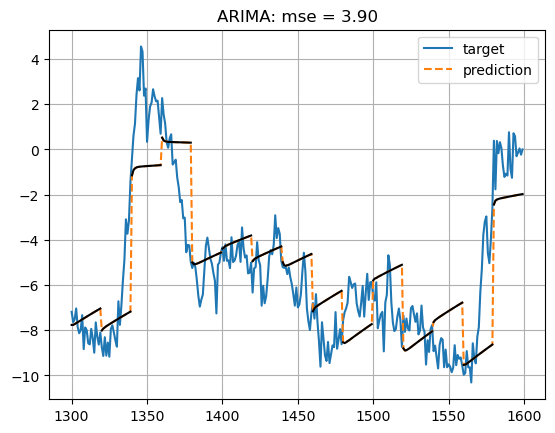

In [54]:
tsf_arima = ARIMA_Forecaster(p=5, d=0, q=1, trend = "n")
tsf_arima.cross_val_exp(Seq = T_seq, X_seq_start = 0, y_seq_length = 20, test_indices = list(range(1300,1600,20)))
mse_arima = tsf_arima.cv_results["mse_fold"].mean()
tsf_arima.plot_targets_predictions(kind = "expanding", title = "ARIMA: mse = {:.2f}".format(mse_arima))

Let's try **SARIMA** instead to take into account the seasonality. We'll use p=1, d=0, q=0, P=1, D=0, Q=0, s=200. But we get a worse mse than the ARIMA model. I don't expect to get great results anyway, as the sequence is not strictly periodic. Also, SARIMA is prohibitively time-consuming.

<Figure size 640x480 with 0 Axes>

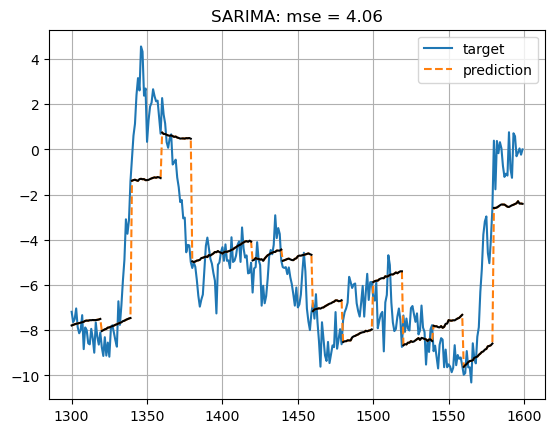

In [55]:
tsf_sarima = SARIMA_Forecaster(p=1, d=0, q=0, P=1, D=0, Q=0, s=200, trend = "n")
tsf_sarima.cross_val_exp(Seq = T_seq, X_seq_start = 0, y_seq_length = 20, test_indices = list(range(1300,1600,20))) 
mse_sarima = tsf_sarima.cv_results["mse_fold"].mean() 
tsf_sarima.plot_targets_predictions(kind = "expanding", title = "SARIMA: mse = {:.2f}".format(mse_sarima)) 

Let's do an **exponential smoothing** fit. Had trouble getting a good seasonal fit. So I just did a regular fit. Looks like we got a simple random walk model, basically. 

<Figure size 640x480 with 0 Axes>

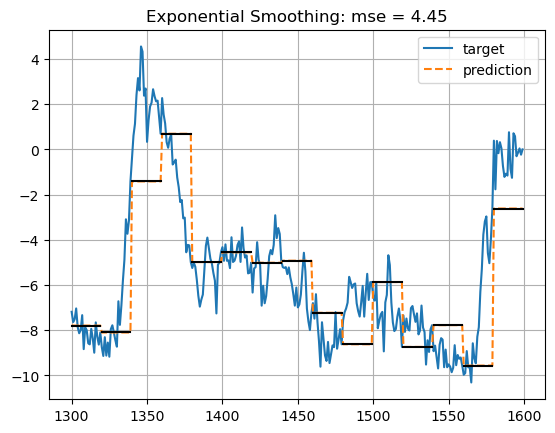

In [56]:
tsf_exps = exps_Forecaster(optimized = True)
tsf_exps.cross_val_exp(Seq = T_seq, X_seq_start = 0, y_seq_length = 20, test_indices = list(range(1300,1600,20)))
mse_exp = tsf_exps.cv_results["mse_fold"].mean()
tsf_exps.plot_targets_predictions(kind = "expanding", title = "Exponential Smoothing: mse = {:.2f}".format(mse_exp))

Now let's try another model, **DE_Forecaster**. It a simple linear Ridge regression model that takes the last X_seq_length terms in the sequence and tries to predicts the next one. Once the best fit model is established, it then recursively predicts the next y_seq_length terms in the sequence. Essentially it is like ARMA, with q = 0. alpha is a Ridge regularization parameter. It seems the best (X_seq_length, alpha) is (212, 0). This is a much better fit, with an mse = 1.89, that's starting to look like the actual curve.

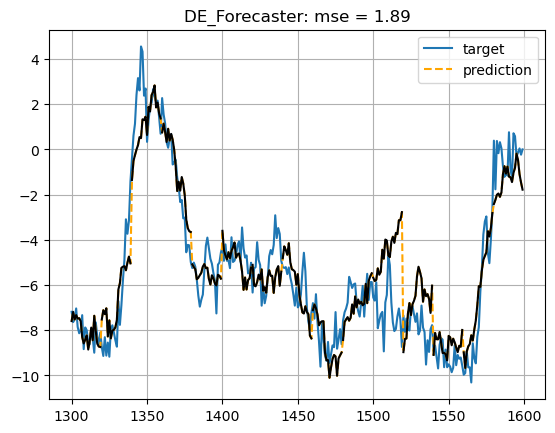

In [57]:
df = create_dataframe(X_seq_length = 212, y_seq_length = 1)
df.fit(T_seq.values)
df.insert_constant(1) 
X, y = df.X, df.y
tsf_de = DE_Forecaster(X_seq_length = 212, y_seq_length = 20, alpha = 0)
tsf_de.cross_val_exp(X, y, test_indices = list(range(1300,1600,20)), start = 212)
mse_de = tsf_de.cv_results["mse_fold"].mean()
tsf_de.plot_targets_predictions(kind = "expanding", title = "DE_Forecaster: mse = {:.2f}".format(mse_de))

Keeping 212 previous terms in the sequence seems like a lot. Let's see which coefficients actually matter. The immediately preceding one matters most, but it seems that almost all are involved for the fine-tuning. The presence of the n-24 term is notable when comparing to the PACF graph up above. And given the roughly 200 time-step periodicity of the sequence, I suppose it's not too surprising that we would want to keep around 200 previous terms. 

In [58]:
tsf_de.coefs_["run 15"][tsf_de.coefs_["run 15"] > 0.1]

X_(n-208)    0.139068
X_(n-196)    0.150243
X_(n-192)    0.132676
X_(n-185)    0.137536
X_(n-182)    0.105786
X_(n-162)    0.106814
X_(n-146)    0.124786
X_(n-123)    0.128868
X_(n-24)     0.139428
X_(n-1)      0.978952
Name: run 15, dtype: float64

Now let's try another model, an **RE_Forecaster**. Like the one above, it's a simple linear Ridge regression model that takes the last X_seq_length terms in the sequence, but this time it tries to predict the y_seq_length terms all at once; it's a multivariate linear Ridge regression model. Again, alpha is a Ridge regularization parameter. Playing around with the parameters, it seems the best (X_seq_length, alpha) is (212, 100). This is a pretty good fit, with an mse = 2.11, but not quite as good as the previous model's mse of 1.89. So it looks like it's better, at least in this case, to regress on the first next temperature and roll forward the predictions on the other desired temperatures (as the previous model does) than it is to try to predict all the succeeding temperatures at once.

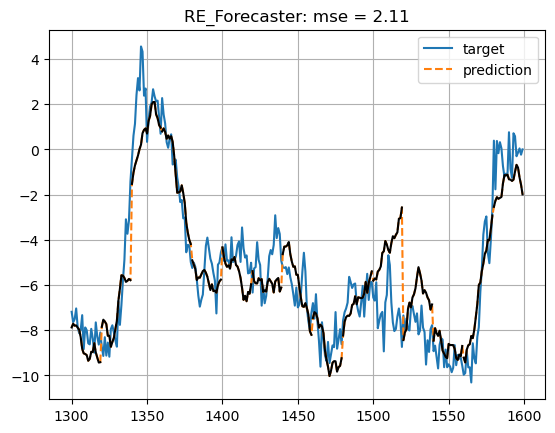

In [59]:
df = create_dataframe(X_seq_length = 212, y_seq_length = 20)
df.fit(T_seq.values)
df.insert_constant(1)
X, y = df.X, df.y
tsf_re = RE_Forecaster(X_seq_length = 215, y_seq_length = 20, alpha = 100)
tsf_re.cross_val_exp(X, y, test_indices = list(range(1300,1600,20)), start = 212)
mse_re = tsf_re.cv_results["mse_fold"].mean()
tsf_re.plot_targets_predictions(kind = "expanding", title = "RE_Forecaster: mse = {:.2f}".format(mse_re))

Now we'll do an **RNN Encoder-Decoder**. It takes an X_seq_length number of previous steps in the sequence, encodes it, and feeds it into the hidden state of the decoder, which takes y_seq_length inputs of 0's and tries to predict the next y_seq_length terms. rnn_layers is a list that specifies the number of recurrent units per layer per time step. So rnn_layers = [20,20,20] would specify three layers of 20 units per time step. nn_layers is a list that specifies the number of nodes per layer per time step connected to the last layer of the recurrent units. So nn_layers = [10,5,1] would specify that we connect the last rnn layer to 10, then 5, then 1 normal nodes. Since I'm using a linear activation function, just the simplest architecture nn_layer = [1] suffices. The best combination is X_seq_length = 20, lr = 0.001, epochs = 21 (doesn't seem to improve much past this). But our result isn't that great compared to the previous two models.

epoch: 0	training_loss: 0.13791	validation_loss: 0.02974
epoch: 10	training_loss: 0.07366	validation_loss: 0.04966
epoch: 20	training_loss: 0.07204	validation_loss: 0.04668


epoch: 0	training_loss: 0.16044	validation_loss: 0.08201
epoch: 10	training_loss: 0.07493	validation_loss: 0.10076
epoch: 20	training_loss: 0.07074	validation_loss: 0.09614


epoch: 0	training_loss: 0.18162	validation_loss: 0.6439
epoch: 10	training_loss: 0.07442	validation_loss: 0.24363
epoch: 20	training_loss: 0.07036	validation_loss: 0.22119


epoch: 0	training_loss: 0.14797	validation_loss: 0.07866
epoch: 10	training_loss: 0.07752	validation_loss: 0.0453
epoch: 20	training_loss: 0.06726	validation_loss: 0.02282


epoch: 0	training_loss: 0.16478	validation_loss: 0.02831
epoch: 10	training_loss: 0.0707	validation_loss: 0.04705
epoch: 20	training_loss: 0.0704	validation_loss: 0.02769


epoch: 0	training_loss: 0.15369	validation_loss: 0.03873
epoch: 10	training_loss: 0.0726	validation_loss: 0.00603
epoch: 20	train

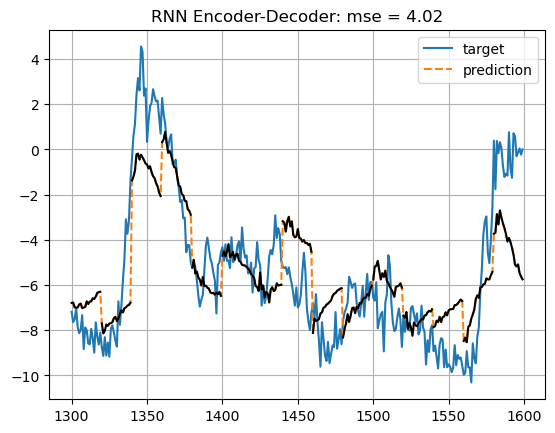

In [60]:
df = create_dataframe(X_seq_length = 20, y_seq_length = 20)
df.fit(T_seq.values)
df.insert_placeholders(20,0)
X, y = df.X, df.y 
tsf_rnn = RNN_Forecaster(X_seq_length = 20, y_seq_length = 20, rnn_layers = [20], nn_layers = [1], activation = "linear", \
                         scaler = ("ab", {"a":-1, "b":1}), optimizer = ("Adam", {"lr":0.001}), loss = "MSE", epochs = 21, batch_size = 30)
tsf_rnn.cross_val_exp(X, y, test_indices = list(range(1300,1600,20)), start = 20) 
mse_rnn = tsf_rnn.cv_results["mse_fold"].mean() 
tsf_rnn.plot_targets_predictions(kind = "expanding", title = "RNN Encoder-Decoder: mse = {:.2f}".format(mse_rnn))

We can do an **LSTM Encoder-Decoder** too. It works just like the RNN Encoder-Decoder. Best out of a limited number of tries was X_seq_length = 20, lr = 0.005, epochs = 21 (again, not much improvement past this). We get better results, but still not as good as the simpler linear models.

epoch: 0	training_loss: 0.12778	validation_loss: 0.0553
epoch: 10	training_loss: 0.07686	validation_loss: 0.0662
epoch: 20	training_loss: 0.06245	validation_loss: 0.10421


epoch: 0	training_loss: 0.12006	validation_loss: 0.10535
epoch: 10	training_loss: 0.07026	validation_loss: 0.08336
epoch: 20	training_loss: 0.06232	validation_loss: 0.05592


epoch: 0	training_loss: 0.12215	validation_loss: 0.38497
epoch: 10	training_loss: 0.07614	validation_loss: 0.13135
epoch: 20	training_loss: 0.06366	validation_loss: 0.28046


epoch: 0	training_loss: 0.11898	validation_loss: 0.05446
epoch: 10	training_loss: 0.06794	validation_loss: 0.03019
epoch: 20	training_loss: 0.06173	validation_loss: 0.00572


epoch: 0	training_loss: 0.14176	validation_loss: 0.01967
epoch: 10	training_loss: 0.06699	validation_loss: 0.0356
epoch: 20	training_loss: 0.05836	validation_loss: 0.02448


epoch: 0	training_loss: 0.12255	validation_loss: 0.02947
epoch: 10	training_loss: 0.06751	validation_loss: 0.01634
epoch: 20	tra

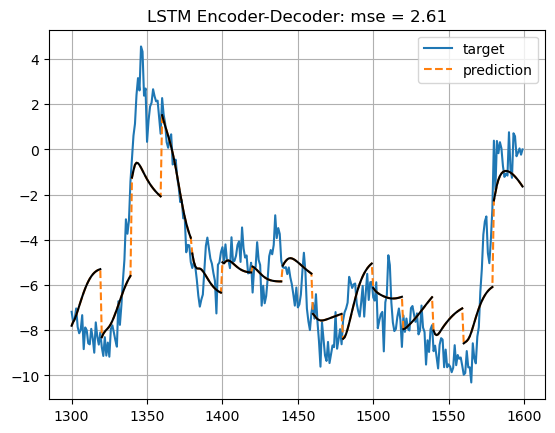

In [61]:
df = create_dataframe(X_seq_length = 20, y_seq_length = 20)
df.fit(T_seq.values)
df.insert_placeholders(20,0)
X, y = df.X, df.y
tsf_lstm = LSTM_Forecaster(X_seq_length = 20, y_seq_length = 20, lstm_layers = [20], nn_layers = [1], activation = "linear", \
                         scaler = ("ab", {"a":-1, "b":1}), optimizer = ("Adam", {"lr":0.005}), loss = "MSE", epochs = 21, batch_size = 20)
tsf_lstm.cross_val_exp(X, y, test_indices = list(range(1300,1600,20)), start = 20) 
mse_lstm = tsf_lstm.cv_results["mse_fold"].mean()
tsf_lstm.plot_targets_predictions(kind = "expanding", title = "LSTM Encoder-Decoder: mse = {:.2f}".format(mse_lstm))

Last thing. Can adding variables to incorporate the Milankovitch cycle help at all? We can represent the periodic cause that produces this effect by modeling it as the inverse Fourier transform of a function with a period of 100,000 years, i.e., 200 time-steps. We can  write this weather variable, $w_j,$ as: $w_j = \sum_{k=1}^{n}(a_k\cos(2\pi k j/200) + b_k\sin(2\pi kj/200)),$ where j runs between 0 and 1600. In practice, we'll just keep a couple k's; I'll let n be the number kept (ultimately I'll choose n = 1, as that seems to yield the best results). So I'll have to add n columns to the dataframe. The columns will be the trig functions themselves, i.e. $\cos_k = \cos(2\pi kj/200)$, $\sin_k = \sin(2\pi kj/200).$ The ML algorithm will determine the best fit inverse Fourier transform coefficients $a_k$, and $b_k$. We'll use the **DE_Vector_Forecaster** model on this data. This model will perform a Ridge regression on the previous X_seq_length time steps of data (consisting now of T_seq itself, as well as the columns of trig data sin_k, cos_k) as well as the concurrent y_seq_length = 20 time steps of sin_k and cos_k data (since we know the weather variable trig functions at all time steps) to predict the first new value of T_seq. Then it will take this linear model and recursively predict the next y_seq_length - 1 = 19 values of T_seq. As can see below, including the weather variable helps drive down the mse just a tad.

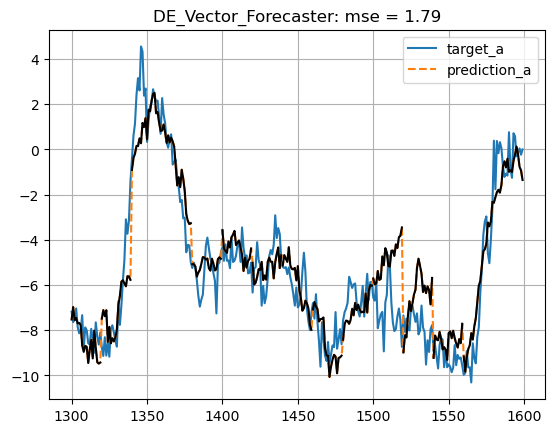

In [62]:
n = 1
Trig_cols = []
for k in range(1,1+n):
    sin_k = [numpy.sin(2*numpy.pi*k*j/200) for j in range(len(T_seq))]
    cos_k = [numpy.cos(2*numpy.pi*k*j/200) for j in range(len(T_seq))]
    Trig_cols.extend([sin_k, cos_k])

df = create_dataframe(X_seq_length = 212, y_seq_length = 20)
df.fit_vec(*([T_seq.values.tolist()]+Trig_cols))
df.insert_constant(tuple([1]+2*[0 for k in range(1,1+n)]))

X, y = df.X, df.y
tsf_dev = DE_Vector_Forecaster(X_seq_length = 212, y_seq_length = 20, alpha = 0)
tsf_dev.cross_val_exp(df.X, df.y, test_indices = list(range(1300,1600,20)), start = 212, pred_cols = [0])
mse_dev = tsf_dev.cv_results["mse_fold"].mean()
tsf_dev.plot_targets_predictions(kind = "expanding", title = "DE_Vector_Forecaster: mse = {:.2f}".format(mse_dev))

So looks like the **DE_Vector_Forecaster** model is the best. Let's see what our prediction is for the temperature over the next 10,000 years (20 time-steps). This is our prediction for T_seq[1600:1620]. I'll add 20 0s to T_seq (these values are ignored by the ML model, but they need to be there), and also extend the sin_k and cos_k columns by 20 time-steps. And then I'll redo the plot, extending it out to time step 1620. Looks like an overall cooling trend is predicted. 

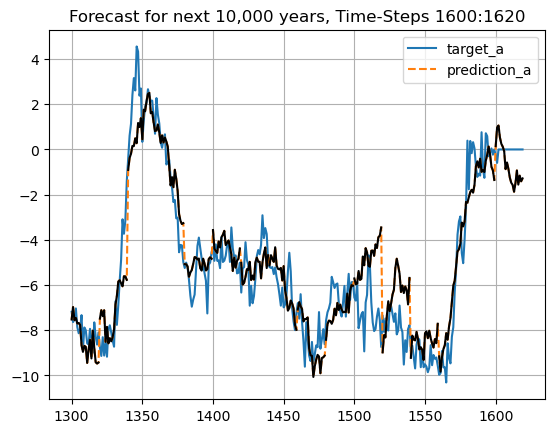

In [63]:
T_seq = pandas.Series(T_seq.values.tolist() + [0 for j in range(20)])

n = 1
Trig_cols = []
for k in range(1,1+n):
    sin_k = [numpy.sin(2*numpy.pi*k*j/200) for j in range(len(T_seq)+20)]
    cos_k = [numpy.cos(2*numpy.pi*k*j/200) for j in range(len(T_seq)+20)]
    Trig_cols.extend([sin_k, cos_k])

df = create_dataframe(X_seq_length = 212, y_seq_length = 20)
df.fit_vec(*([T_seq.values.tolist()]+Trig_cols))
df.insert_constant(tuple([1]+2*[0 for k in range(1,1+n)]))

X, y = df.X, df.y
tsf_dev = DE_Vector_Forecaster(X_seq_length = 212, y_seq_length = 20, alpha = 0)
tsf_dev.cross_val_exp(df.X, df.y, test_indices = list(range(1300,1620,20)), start = 212, pred_cols = [0])
tsf_dev.plot_targets_predictions(kind = "expanding", title = "Forecast for next 10,000 years, Time-Steps 1600:1620")